In [172]:
import pandas as pd
import os
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
from matplotlib.ticker import MaxNLocator

import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
from numpy.testing import assert_almost_equal

from urllib.request import urlretrieve

from imblearn.over_sampling import SMOTE, KMeansSMOTE, SVMSMOTE, BorderlineSMOTE, ADASYN

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import *

from IPython.core.display import display, HTML
from IPython.display import Image

from scipy.spatial.distance import pdist, cdist, squareform

np.random.seed(13)

pd.set_option('display.max_columns', None) # to display all columns

# DATA ACQUISITION

We have uploaded the CSVs as a release of the Github repository so that it's possible to download them if they aren't locally available.

In [173]:
csv_names = ["movies.csv", "ratings.csv", "genome-scores.csv", "genome-tags.csv", "links.csv", "tags.csv"]
datasets_names = [i[:-4].replace("-", "_") for i in csv_names]

local_csv_dir = os.path.join("datasets", "datasets-ml-latest")
remote_csv_dir = "http://github.com/MickPerl/DataAnalyticsProject/releases/download/datasets_reduced/"

In [174]:
if not os.path.exists(os.path.join("datasets", "datasets-ml-25m")):
    os.makedirs(os.path.join("datasets", "datasets-ml-25m"))
if not os.path.exists(os.path.join("datasets", "datasets-ml-latest")):
    os.makedirs(os.path.join("datasets", "datasets-ml-latest"))

In [175]:
def name(dataset_name) :
    return "_".join(['df', dataset_name])

The following code tries to read the csv file given the local path: in case of failure, it download the file from the remote path to the local path so that it can successfully read them.

In [176]:
for i in range(len(csv_names)):
    local_csv_path = os.path.join(local_csv_dir, csv_names[i])
    
    '''
    nella versione da consegnare si utilizzerà la funzione name(), così da non occupare memoria con copie di DataFrame
    '''
    try : 
        # if the path exists as well as the file, read directly  
        globals()[datasets_names[i]] = pd.read_csv(local_csv_path)     
        # globals()[name(datasets_names[i])] = pd.read_csv(path)

    except FileNotFoundError:
        print(f"Download in progress of {csv_names[i]}")
        remote_csv_path = os.path.join(remote_csv_dir, csv_names[i])
        file, _ = urlretrieve(url = remote_csv_path, filename=local_csv_path)
        globals()[datasets_names[i]] = pd.read_csv(file)
        # globals()[name(datasets_names[i])] = pd.read_csv(file[0])

In [177]:
# prima della consegna, eliminare queste righe
df_movies = movies.copy()
df_ratings = ratings.copy()
df_links = links.copy()
df_genome_scores = genome_scores.copy()
df_genome_tags = genome_tags.copy()
df_tags = tags.copy()

# DATA PREPROCESSING

## Data manipulation

Within this section, we go through the `DataFrame`'s obtained by executing the previous data acquisition: we highlight their peculiarities and join them in order to end up getting the complete dataset.

### df_movies

In [178]:
output = df_movies.head().style.set_caption("df_movies")._repr_html_()
display(HTML(output))

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


The `df_movies` DataFrame contains the following information with regard to $62423$ films.

In [179]:
len(df_movies)

58098

Each film has a different title, therefore we have considered it as a negligible information: however, before dropping the corresponding column `title`, we have extracted from it the **year** of each film which could be a relevant feature.

In [180]:
title_trimmed = df_movies['title'].str.strip()
df_movies["year"] = title_trimmed.str.slice(start=-5, stop=-1)

df_movies["title_length"] = df_movies['title'].str.len()
df_movies.drop('title', inplace=True, axis=1)

In [181]:
# descrivere questa riga
df_movies.iloc[:,2] = pd.to_numeric(df_movies.iloc[:,2], errors='coerce')

For each film, the dataset `df_movies` stores its genres by a pipe-separated list:

In [182]:
df_movies.genres.head()

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

Consequently, we have decided to add one column for each possible genre: if the film belongs to a certain genre, the corresponding cell will contain `1`, `0` otherwise.
To do that, first of all we instantiate the class `MultiLabelBinarizer` from the `preprocessing` module of the `sklearn` library: its method `fit_transform` takes as input the set of labels for each samples and outputs a matrix of shape (# samples, # unique labels) such that each cell has `1` if the corresponding film belongs to the corresponding genre, `0` otherwise.\
Then, we convert this matrix to a `DataFrame` object whose columns are the genres' name; eventually, the result is joined with `df_movies` DataFrame.

In [183]:
mlb = MultiLabelBinarizer()
df_movies = df_movies.join(pd.DataFrame(
                mlb.fit_transform(df_movies.pop('genres').str.split('|')),
                index=df_movies.index,
                columns=mlb.classes_))
        
df_movies.head()

,movieId,year,title_length,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1995.0,16,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,1995.0,14,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,1995.0,23,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,1995.0,24,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,1995.0,34,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### df_genome_tags and df_genome_scores

`df_genome_scores` contains tag relevance scores for movies.\
The set of relevances regarding a film is its *genome*: thus, the genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.).  

In [184]:
output = df_genome_scores.head().style.set_caption('First 5 rows of df_genome_scores')._repr_html_()
display(HTML(output))

,movieId,tagId,relevance
0,1,1,0.029000
1,1,2,0.023750
2,1,3,0.054250
3,1,4,0.068750
4,1,5,0.160000


ci sono 15584448 rating degli utenti

In [185]:
len(df_genome_scores)

14862528

In particular, only $13816$ films out of $62423$ have a genome: the remaining 48607 aren't characterized by any tag.

In [186]:
len(df_genome_scores.groupby("movieId"))

13176

The structure of `df_genome_scores` is a dense matrix: each movie within it has a value for every tag in the genome as it's possible to prove through grouping by `movieId` value and seeing that the number of unique tags is the same over all films.

In [187]:
print(*df_genome_scores.groupby("movieId").count().tagId.unique())

1128


to add

In [188]:
len(df_genome_tags)

1128

We can continue merging `df_genome_scores` with `df_genome_tags` which explicits every tag.

In [189]:
def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

display_side_by_side([df_genome_scores.head(), df_genome_tags.head()], ['df_genome_scores', 'df_genome_tags'])

In [190]:
df_genome = pd.merge(df_genome_scores, df_genome_tags, on="tagId", how="left")

After that, we want to manipulate the `df_genome` DataFrame in order to relate every film to its genome. 

In [191]:
df_genome = df_genome.pivot(index='movieId', columns='tag', values="relevance")
df_genome.head()

tag,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,3d,70mm,80s,9/11,aardman,aardman studios,abortion,absurd,action,action packed,adaptation,adapted from:book,adapted from:comic,adapted from:game,addiction,adolescence,adoption,adultery,adventure,affectionate,afi 100,afi 100 (laughs),afi 100 (movie quotes),africa,afterlife,aging,aids,airplane,airport,alaska,alcatraz,alcoholism,alien,alien invasion,aliens,allegory,almodovar,alone in the world,alter ego,alternate endings,alternate history,alternate reality,alternate universe,amazing cinematography,amazing photography,american civil war,amnesia,amy smart,android(s)/cyborg(s),androids,animal movie,animals,animated,animation,anime,antarctica,anti-hero,anti-semitism,anti-war,apocalypse,archaeology,argentina,arms dealer,arnold,art,art house,artificial intelligence,artist,artistic,artsy,assassin,assassination,assassins,astronauts,atheism,atmospheric,australia,australian,author:alan moore,author:neil gaiman,autism,aviation,awesome,awesome soundtrack,awful,bad,bad acting,bad cgi,bad ending,bad plot,bad science,bad script,bad sequel,ballet,bank robbery,baseball,based on a book,based on a comic,based on a play,based on a true story,based on a tv show,based on a video game,based on book,based on comic,based on true story,basketball,batman,bdsm,beatles,beautiful,beautiful scenery,beautifully filmed,beauty pageant,beer,berlin,best of 2005,best war films,betrayal,better than expected,better than the american version,biblical,big budget,biographical,biography,biopic,birds,biting,bittersweet,bizarre,black and white,black comedy,blaxploitation,bleak,blindness,blood,bloody,boarding school,boat,bollywood,bombs,bond,book,book was better,books,boring,boring!,boston,bowling,boxing,brainwashing,brazil,breathtaking,brilliant,british,british comedy,broadway,brothers,brutal,brutality,buddy movie,bullshit history,bullying,business,c.s. lewis,california,camp,campy,canada,cancer,cannibalism,caper,capitalism,car chase,carrie-anne moss,cars,cartoon,casino,catastrophe,cathartic,catholicism,censorship,cerebral,cgi,character study,chase,cheating,cheerleading,cheesy,chess,chicago,chick flick,child abuse,childhood,children,china,chocolate,chris tucker,christian,christianity,christmas,cia,cinematography,circus,civil war,classic,classic car,classical music,claustrophobic,claymation,clever,clones,cloning,clowns,coen bros,coen brothers,cold war,college,colonialism,colourful,comedy,comic,comic book,comic book adaption,comics,coming of age,coming-of-age,communism,compassionate,competition,complex,complex characters,complicated,complicated plot,computer animation,computer game,computers,con artists,con men,confrontational,confusing,conspiracy,conspiracy theory,controversial,cooking,cool,corny,corporate america,corruption,costume drama,courage,court,courtroom,courtroom drama,crappy sequel,crazy,creativity,creepy,crime,crime gone awry,criterion,cross dressing,crude humor,cuba,cult,cult classic,cult film,culture clash,cute,cute!,cyberpunk,cyborgs,cynical,dance,dancing,dark,dark comedy,dark fantasy,dark hero,dark humor,dc comics,deadpan,death,death penalty,demons,depp & burton,depressing,depression,desert,destiny,detective,devil,dialogue,dialogue driven,dinosaurs,directorial debut,disability,disappointing,disaster,disney,disney animated feature,distopia,disturbing,divorce,doctors,documentary,dog,dogs,dolphins,downbeat,dr. seuss,dragon,dragons,drama,dramatic,dreamlike,dreams,dreamworks,drinking,drug abuse,drug addiction,drugs,dumb,dumb but funny,dynamic cgi action,dysfunctional family,dystopia,dystopic future,earnest,easily confused with other movie(s) (title),east germany,eccentricity,ecology,educational,eerie,effects,egypt,emma watson,emotional,end of the world,england,enigmatic,ennio morricone,enormously long battle scene,ensemble cast,entertaining,entirely dialogue,environment,environmental,epic,erotic,espionage,ethnic conflict,evolution,excellent,excellent script,exceptional acting,exciting,

We can merge the result with `df_movies`.

In [192]:
df = pd.merge(df_movies, df_genome, on="movieId", how = "left")
df.head()

,movieId,year,title_length,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,3d,70mm,80s,9/11,aardman,aardman studios,abortion,absurd,action,action packed,adaptation,adapted from:book,adapted from:comic,adapted from:game,addiction,adolescence,adoption,adultery,adventure,affectionate,afi 100,afi 100 (laughs),afi 100 (movie quotes),africa,afterlife,aging,aids,airplane,airport,alaska,alcatraz,alcoholism,alien,alien invasion,aliens,allegory,almodovar,alone in the world,alter ego,alternate endings,alternate history,alternate reality,alternate universe,amazing cinematography,amazing photography,american civil war,amnesia,amy smart,android(s)/cyborg(s),androids,animal movie,animals,animated,animation,anime,antarctica,anti-hero,anti-semitism,anti-war,apocalypse,archaeology,argentina,arms dealer,arnold,art,art house,artificial intelligence,artist,artistic,artsy,assassin,assassination,assassins,astronauts,atheism,atmospheric,australia,australian,author:alan moore,author:neil gaiman,autism,aviation,awesome,awesome soundtrack,awful,bad,bad acting,bad cgi,bad ending,bad plot,bad science,bad script,bad sequel,ballet,bank robbery,baseball,based on a book,based on a comic,based on a play,based on a true story,based on a tv show,based on a video game,based on book,based on comic,based on true story,basketball,batman,bdsm,beatles,beautiful,beautiful scenery,beautifully filmed,beauty pageant,beer,berlin,best of 2005,best war films,betrayal,better than expected,better than the american version,biblical,big budget,biographical,biography,biopic,birds,biting,bittersweet,bizarre,black and white,black comedy,blaxploitation,bleak,blindness,blood,bloody,boarding school,boat,bollywood,bombs,bond,book,book was better,books,boring,boring!,boston,bowling,boxing,brainwashing,brazil,breathtaking,brilliant,british,british comedy,broadway,brothers,brutal,brutality,buddy movie,bullshit history,bullying,business,c.s. lewis,california,camp,campy,canada,cancer,cannibalism,caper,capitalism,car chase,carrie-anne moss,cars,cartoon,casino,catastrophe,cathartic,catholicism,censorship,cerebral,cgi,character study,chase,cheating,cheerleading,cheesy,chess,chicago,chick flick,child abuse,childhood,children,china,chocolate,chris tucker,christian,christianity,christmas,cia,cinematography,circus,civil war,classic,classic car,classical music,claustrophobic,claymation,clever,clones,cloning,clowns,coen bros,coen brothers,cold war,college,colonialism,colourful,comedy,comic,comic book,comic book adaption,comics,coming of age,coming-of-age,communism,compassionate,competition,complex,complex characters,complicated,complicated plot,computer animation,computer game,computers,con artists,con men,confrontational,confusing,conspiracy,conspiracy theory,controversial,cooking,cool,corny,corporate america,corruption,costume drama,courage,court,courtroom,courtroom drama,crappy sequel,crazy,creativity,creepy,crime,crime gone awry,criterion,cross dressing,crude humor,cuba,cult,cult classic,cult film,culture clash,cute,cute!,cyberpunk,cyborgs,cynical,dance,dancing,dark,dark comedy,dark fantasy,dark hero,dark humor,dc comics,deadpan,death,death penalty,demons,depp & burton,depressing,depression,desert,destiny,detective,devil,dialogue,dialogue driven,dinosaurs,directorial debut,disability,disappointing,disaster,disney,disney animated feature,distopia,disturbing,divorce,doctors,documentary,dog,dogs,dolphins,downbeat,dr. seuss,dragon,dragons,drama,dramatic,dreamlike,dreams,dreamworks,drinking,drug abuse,drug addiction,drugs,dumb,dumb but funny,dynamic cgi action,dysfunctional family,dystopia,dystopic future,earnest,easily confused with other movie(s) (title),east germany,eccentricity,ecology,educational,eerie,effects,egypt,emma watson,emotional,end of the world,england,enigmatic,ennio morricone,enormously l

### df_rating

Each row of `df_ratings` DataFrame represents one rating of one movie by one user, and has the following format:

In [193]:
output = df_ratings.head().style.set_caption("table df_ratings")._repr_html_()
display(HTML(output))

,userId,movieId,rating,timestamp
0,1,307,3.500000,1256677221
1,1,481,3.500000,1256677456
2,1,1091,1.500000,1256677471
3,1,1257,4.500000,1256677460
4,1,1449,4.500000,1256677264


In [194]:
len(df_ratings)

27753444

*Ratings* are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).\
*Timestamps* represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

We select only the `movieId` and `rating` columns and we average ratings relating each film and then we join the result with the complete DataFrame.

In [195]:
df_ratings = df_ratings.iloc[:,[1,2]]

df_ratings = df_ratings.groupby(by='movieId').rating.agg(rating_mean= 'mean', ratings_count= 'count')
df_ratings.head()

,rating_mean,ratings_count
movieId,,
1,3.886649,68469
2,3.246583,27143
3,3.173981,15585
4,2.874540,2989
5,3.077291,15474


Ratings are indicated for $59047$ out of $62423$.

In [196]:
len(df_ratings)

53889

In [197]:
df = pd.merge(df, df_ratings, on="movieId", how="left")

## Data cleaning

### Checking missing data

#### Films without rating

There are $3376$ films without a rating.

In [198]:
sum(df.rating_mean.isna())

4209

Since the rating is the label and the cardinality of the complete dataset is big, we can drop these films.

In [199]:
df.dropna(subset=['rating_mean'], inplace=True)

The new cardinality is $59047$.

In [200]:
len(df)

53889

In [201]:
df.ratings_count = df.ratings_count.astype('int') 

#### Films without tags and/or genres
There are $40713$ films without a relevance for any tag.

In [202]:
sum((df.iloc[:, 23:-2]).isna().all(axis = 1))

40713

We save these films in a temporary DataFrame.

In [203]:
df_without_tags = df[df.iloc[:, 23:-2].isna().all(axis = 1)]

Given this subset, we want to look for those films without any genres.

In [204]:
df_without_tags_nor_genres = df_without_tags[df_without_tags['(no genres listed)'] == 1]

In [205]:
len(df_without_tags_nor_genres)

3703

We drop these samples.

In [206]:
len(df)

53889

In [207]:
rows_to_be_deleted = df.loc[df["movieId"].isin(df_without_tags_nor_genres["movieId"])].index

In [208]:
df.drop(rows_to_be_deleted, axis=0, inplace=True)

In [209]:
len(df)

50186

Regarding remaining films without tags, we set to `0` their relevance under the different tags.

In [210]:
df.iloc[:, 23:-2] = df.iloc[:, 23:-2].fillna(0)

After the dropping, there are still $29$ films which don't belong to any genres.

In [211]:
sum(df['(no genres listed)'] == 1)

29

We can prove that these films are those which have `0` under the columns of the genres.

In [212]:
sum((df.iloc[:, 4:23] == 0).all(axis = 1)) == sum(df['(no genres listed)'] == 1)

True

Since the absence of genres is somehow expressed by the genres columns, it's possible to drop the `(no genres listed)`.

In [213]:
df.drop(['(no genres listed)'], inplace=True, axis=1)

#### Films without years
There are $370$ films without an year.

In [214]:
sum(df.year.isna())

103

To decide the value to substitute to `na`, we plot the distribution of the values.

In [215]:
df_year_without_na = df.year[-pd.isna(df.year)]

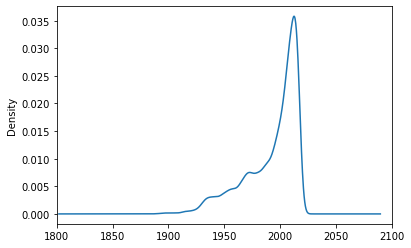

In [216]:
df_year_without_na.plot(kind ='density')
plt.xlim([1800, 2100])
plt.show()

Since it's not simmetric, we decide to fill `na` values with the *median*.

In [217]:
df.year = df.loc[:, 'year'].fillna(np.median(df_year_without_na)).astype('int')

In [218]:
'''
    alternative code in case .fillna is too computationally intensive
'''

# df.to_csv("df_per_fillna.csv", index=False)
# 
# #os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
# os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask
# 
# import dask
# import modin.pandas as pd_mod
# df_temp = pd_mod.read_csv("df_per_fillna.csv")
# df_temp.fillna(value=0)
# df_temp.to_csv("df_without_na.csv")
# df = pd.read_csv("df_without_na.csv")

'\n    alternative code in case .fillna is too computationally intensive\n'

We can check the absence of `Null` or `Na` values.

In [219]:
sum(pd.isna(df).any(axis=1))

0

After checking missing data and before checking duplicates, we drop the `movieId` column since contains unique values which are useful only to indexing purposes.

In [220]:
df.drop('movieId', inplace=True, axis=1)

### Checking duplicates 

There are $393$ duplicated rows.

In [221]:
sum(df.duplicated())

393

We have deleted them by keeping the first.

In [111]:
df.drop_duplicates(inplace=True)

So that, there aren't any duplicated row.

In [112]:
sum(df.duplicated())

0

In [113]:
len(df)

49793

## Data Trasformation

### Continuous label discretization

Binning technique

In [114]:
binning = pd.cut(df['rating_mean'], bins=9, labels=False)
df['bin_y'] = binning

### Train/Test/Validation set splitting

In [115]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=13, stratify=df['bin_y'])
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=13, stratify=df_train['bin_y'])

### Evaluating labels' imbalance in Training Set

In [116]:
if not os.path.exists("images"):
    os.makedirs("images")

In [117]:
df_train.bin_y.value_counts()

5    11274
4     8249
6     7539
3     3986
2     1884
7     1104
0      745
1      728
8      341
Name: bin_y, dtype: int64

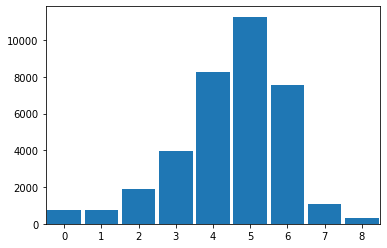

In [118]:
plt.bar(df_train.bin_y.value_counts().index, height=df_train.bin_y.value_counts(), width=0.9)
plt.xlim([-0.5, 8.5])
plt.savefig(os.path.join("images", "Discrete labels before SMOTE.png"),facecolor='white', transparent=False)
plt.show()

Smoothing by bin boundaries

#### Smote

Synthetic Minority Over-sampling

In [119]:
len(df_train)

35850

In [120]:
sm = SMOTE(random_state=43)
df_train, y_train_categorical = sm.fit_resample(df_train, df_train['bin_y'])

In [121]:
# from imblearn.under_sampling import RandomUnderSampler 
# sm = RandomUnderSampler(random_state=42)
# df_train, y_train_categorical = sm.fit_resample(temp, temp['bin_y'])

In [122]:
# from imblearn.combine import SMOTEENN 
# sm = SMOTEENN(random_state=43)
# df_train, y_train_categorical = sm.fit_resample(temp, temp['bin_y'])

In [123]:
# from imblearn.combine import SMOTETomek 
# sm = SMOTETomek(random_state=42)
# df_train, y_train_categorical = sm.fit_resample(temp, temp['bin_y'])

In [124]:
# from imblearn.under_sampling import ClusterCentroids 
# sm = ClusterCentroids(random_state=42, sampling_strategy="all")
# df_train, y_train_categorical = sm.fit_resample(temp, temp['bin_y'])

In [125]:
all(df_train['bin_y'] == y_train_categorical)

True

In [126]:
len(df_train)

101466

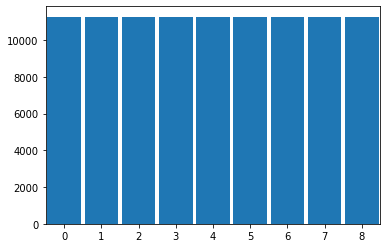

In [127]:
plt.bar(y_train_categorical.value_counts().index, height=y_train_categorical.value_counts(), width=0.9)
plt.xlim([-0.5, 8.5])
plt.savefig(os.path.join("images", "Discrete labels before SMOTE.png"),facecolor='white', transparent=False)
plt.show()

#### Checking new duplicates

In [128]:
df_train.duplicated().sum()

21807

In [129]:
df_train.drop_duplicates(inplace=True)

In [130]:
df_train.duplicated().sum()

0

Dopo eliminazione duplicati dal dataset di train, occorre ricavare y_train (la y_train in output da SMOTE contiene i duplicati che si sono prodotti).

In [131]:
y_train_categorical = df_train['bin_y']

#### Smote result

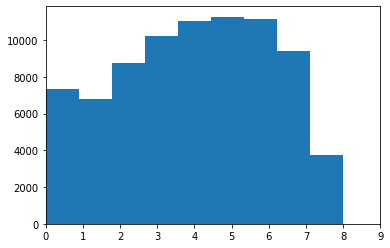

In [132]:
y_train_categorical.hist(bins=9, grid=False)
plt.xlim([0, 9])
plt.show()

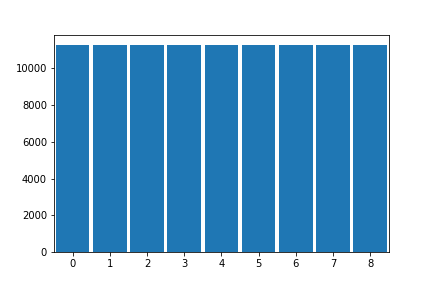

In [133]:
Image(os.path.join("images", "Discrete labels before SMOTE.png"))

distribuzione per label continua)

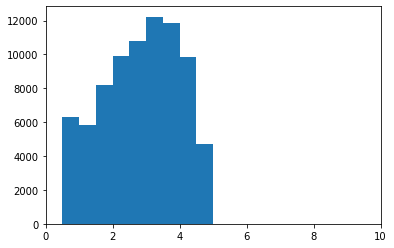

In [134]:
df_train['rating_mean'].hist(bins=9, grid=False)
plt.xlim([0, 10])
plt.show()

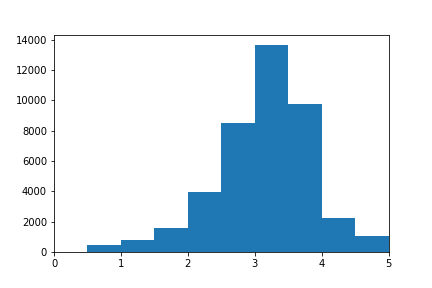

In [135]:
Image(os.path.join("images", "Continuous labels before SMOTE.png"))

### Extracting X and y from Training/Validation/Test Set

In [136]:
# y_train_categorical = df_train['bin_y']
y_train_continuous = df_train['rating_mean']
X_train = df_train
X_train = df_train.drop(columns=['bin_y', 'rating_mean'], axis=1)

y_val_categorical = df_val['bin_y']
y_val_continuous = df_val['rating_mean']
X_val = df_val
X_val = df_val.drop(columns=['bin_y', 'rating_mean'], axis=1)

y_test_categorical = df_test['bin_y']
y_test_continuous = df_test['rating_mean']
X_test = df_test
X_test = df_test.drop(columns=['bin_y', 'rating_mean'], axis=1)

### Evaluating Standardization or Min-Max Scaling

In [137]:
pd.set_option('display.max_rows', df.shape[0]+1)
X_train.describe().loc[['mean', 'min', 'max']]

,year,title_length,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,3d,70mm,80s,9/11,aardman,aardman studios,abortion,absurd,action,action packed,adaptation,adapted from:book,adapted from:comic,adapted from:game,addiction,adolescence,adoption,adultery,adventure,affectionate,afi 100,afi 100 (laughs),afi 100 (movie quotes),africa,afterlife,aging,aids,airplane,airport,alaska,alcatraz,alcoholism,alien,alien invasion,aliens,allegory,almodovar,alone in the world,alter ego,alternate endings,alternate history,alternate reality,alternate universe,amazing cinematography,amazing photography,american civil war,amnesia,amy smart,android(s)/cyborg(s),androids,animal movie,animals,animated,animation,anime,antarctica,anti-hero,anti-semitism,anti-war,apocalypse,archaeology,argentina,arms dealer,arnold,art,art house,artificial intelligence,artist,artistic,artsy,assassin,assassination,assassins,astronauts,atheism,atmospheric,australia,australian,author:alan moore,author:neil gaiman,autism,aviation,awesome,awesome soundtrack,awful,bad,bad acting,bad cgi,bad ending,bad plot,bad science,bad script,bad sequel,ballet,bank robbery,baseball,based on a book,based on a comic,based on a play,based on a true story,based on a tv show,based on a video game,based on book,based on comic,based on true story,basketball,batman,bdsm,beatles,beautiful,beautiful scenery,beautifully filmed,beauty pageant,beer,berlin,best of 2005,best war films,betrayal,better than expected,better than the american version,biblical,big budget,biographical,biography,biopic,birds,biting,bittersweet,bizarre,black and white,black comedy,blaxploitation,bleak,blindness,blood,bloody,boarding school,boat,bollywood,bombs,bond,book,book was better,books,boring,boring!,boston,bowling,boxing,brainwashing,brazil,breathtaking,brilliant,british,british comedy,broadway,brothers,brutal,brutality,buddy movie,bullshit history,bullying,business,c.s. lewis,california,camp,campy,canada,cancer,cannibalism,caper,capitalism,car chase,carrie-anne moss,cars,cartoon,casino,catastrophe,cathartic,catholicism,censorship,cerebral,cgi,character study,chase,cheating,cheerleading,cheesy,chess,chicago,chick flick,child abuse,childhood,children,china,chocolate,chris tucker,christian,christianity,christmas,cia,cinematography,circus,civil war,classic,classic car,classical music,claustrophobic,claymation,clever,clones,cloning,clowns,coen bros,coen brothers,cold war,college,colonialism,colourful,comedy,comic,comic book,comic book adaption,comics,coming of age,coming-of-age,communism,compassionate,competition,complex,complex characters,complicated,complicated plot,computer animation,computer game,computers,con artists,con men,confrontational,confusing,conspiracy,conspiracy theory,controversial,cooking,cool,corny,corporate america,corruption,costume drama,courage,court,courtroom,courtroom drama,crappy sequel,crazy,creativity,creepy,crime,crime gone awry,criterion,cross dressing,crude humor,cuba,cult,cult classic,cult film,culture clash,cute,cute!,cyberpunk,cyborgs,cynical,dance,dancing,dark,dark comedy,dark fantasy,dark hero,dark humor,dc comics,deadpan,death,death penalty,demons,depp & burton,depressing,depression,desert,destiny,detective,devil,dialogue,dialogue driven,dinosaurs,directorial debut,disability,disappointing,disaster,disney,disney animated feature,distopia,disturbing,divorce,doctors,documentary,dog,dogs,dolphins,downbeat,dr. seuss,dragon,dragons,drama,dramatic,dreamlike,dreams,dreamworks,drinking,drug abuse,drug addiction,drugs,dumb,dumb but funny,dynamic cgi action,dysfunctional family,dystopia,dystopic future,earnest,easily confused with other movie(s) (title),east germany,eccentricity,ecology,educational,eerie,effects,egypt,emma watson,emotional,end of the world,england,enigmatic,ennio morricone,enormously long battle scene,ensemble c

The genres columns have `0` or `1` as values.\
We have evaluating the feasibility of the standardization over relevance tags by plotting the distribution.

Since the number of tags is too high, we have plotted the distribution of only 12 randomly sampled tags. 

In [138]:
len(X_train.iloc[:,22:-2].columns)

1126

In [139]:
# columns_sampled = np.random.choice(df.iloc[:,21:-2].columns, 12, replace=False)
# 
# fig = plt.figure(figsize = (20,10))
# fig.subplots_adjust(hspace=0.4, wspace=0.4)
# for i in np.arange(1,13):
#     ax = fig.add_subplot(3, 4, i)
#     X_train[columns_sampled[i-1]].plot(kind ='density')
# plt.show()

Since it turns out that distributions aren't gaussian, we have excluded the standardization: the min-max scaling is pointless as values are already scaled between 0 and 1.  

Regarding the `title_legth` feature, we plot its distribution to evaluate the feasibility of the standardization.

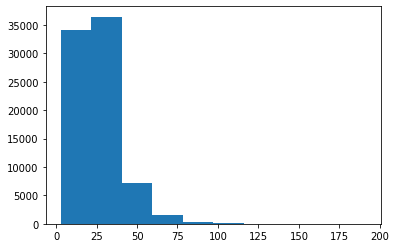

In [140]:
X_train['title_length'].hist(bins=10, grid=False)
plt.show()

Such distribution is not gaussian therefore we end up to apply *min-max scaling* in order to scale values in the range [0,1].

In [141]:
X_train_minmaxscaled = X_train.copy()
X_val_minmaxscaled = X_val.copy()
X_test_minmaxscaled = X_test.copy()

In [142]:
title_length_train_min = np.min(X_train['title_length'])
title_length_train_max = np.max(X_train['title_length'])
title_length_train_range = title_length_train_max - title_length_train_min

X_train_minmaxscaled['title_length'] = (X_train['title_length'] - title_length_train_min) / title_length_train_range
X_val_minmaxscaled['title_length'] = (X_val['title_length'] - title_length_train_min) / title_length_train_range
X_test_minmaxscaled['title_length'] = (X_test['title_length'] - title_length_train_min) / title_length_train_range

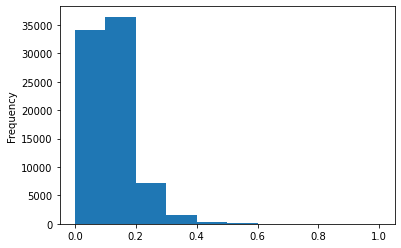

In [143]:
X_train_minmaxscaled['title_length'].plot(kind ='hist')
plt.show()

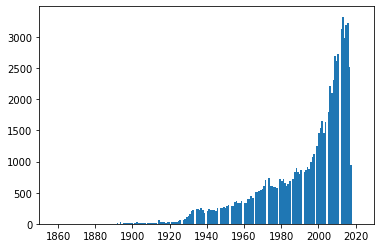

In [144]:
X_train['year'].hist(bins=150, grid=False)
plt.xlim([1850, 2030])
plt.show()

In [145]:
year_train_min = np.min(X_train['year'])
year_train_max = np.max(X_train['year'])
year_train_range = year_train_max - year_train_min

X_train_minmaxscaled['year'] = (X_train['year'] - year_train_min) / year_train_range
X_val_minmaxscaled['year'] = (X_val['year'] - year_train_min) / year_train_range
X_test_minmaxscaled['year'] = (X_test['year'] - year_train_min) / year_train_range

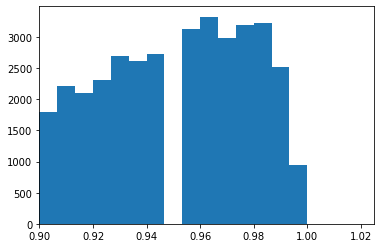

In [146]:
X_train_minmaxscaled['year'].hist(bins=150, grid=False)
plt.xlim([0.9, 1.025])
plt.show()

In [147]:
X_train['ratings_count'].loc[X_train['ratings_count']> 80000]

7592     81815
19717    97040
25247    84545
25270    92406
80449    94726
81181    94667
81537    94852
81604    94963
81991    85597
82018    89983
82634    94988
83094    82871
83150    92193
83798    95073
85094    90990
85144    91312
85659    93160
85873    82708
86597    85733
87083    96872
87174    83442
87426    81457
87841    82342
87928    89225
88016    85843
88104    84788
88213    93720
88896    83682
88995    82424
89000    91104
89033    80141
89797    86644
90531    83946
Name: ratings_count, dtype: int64

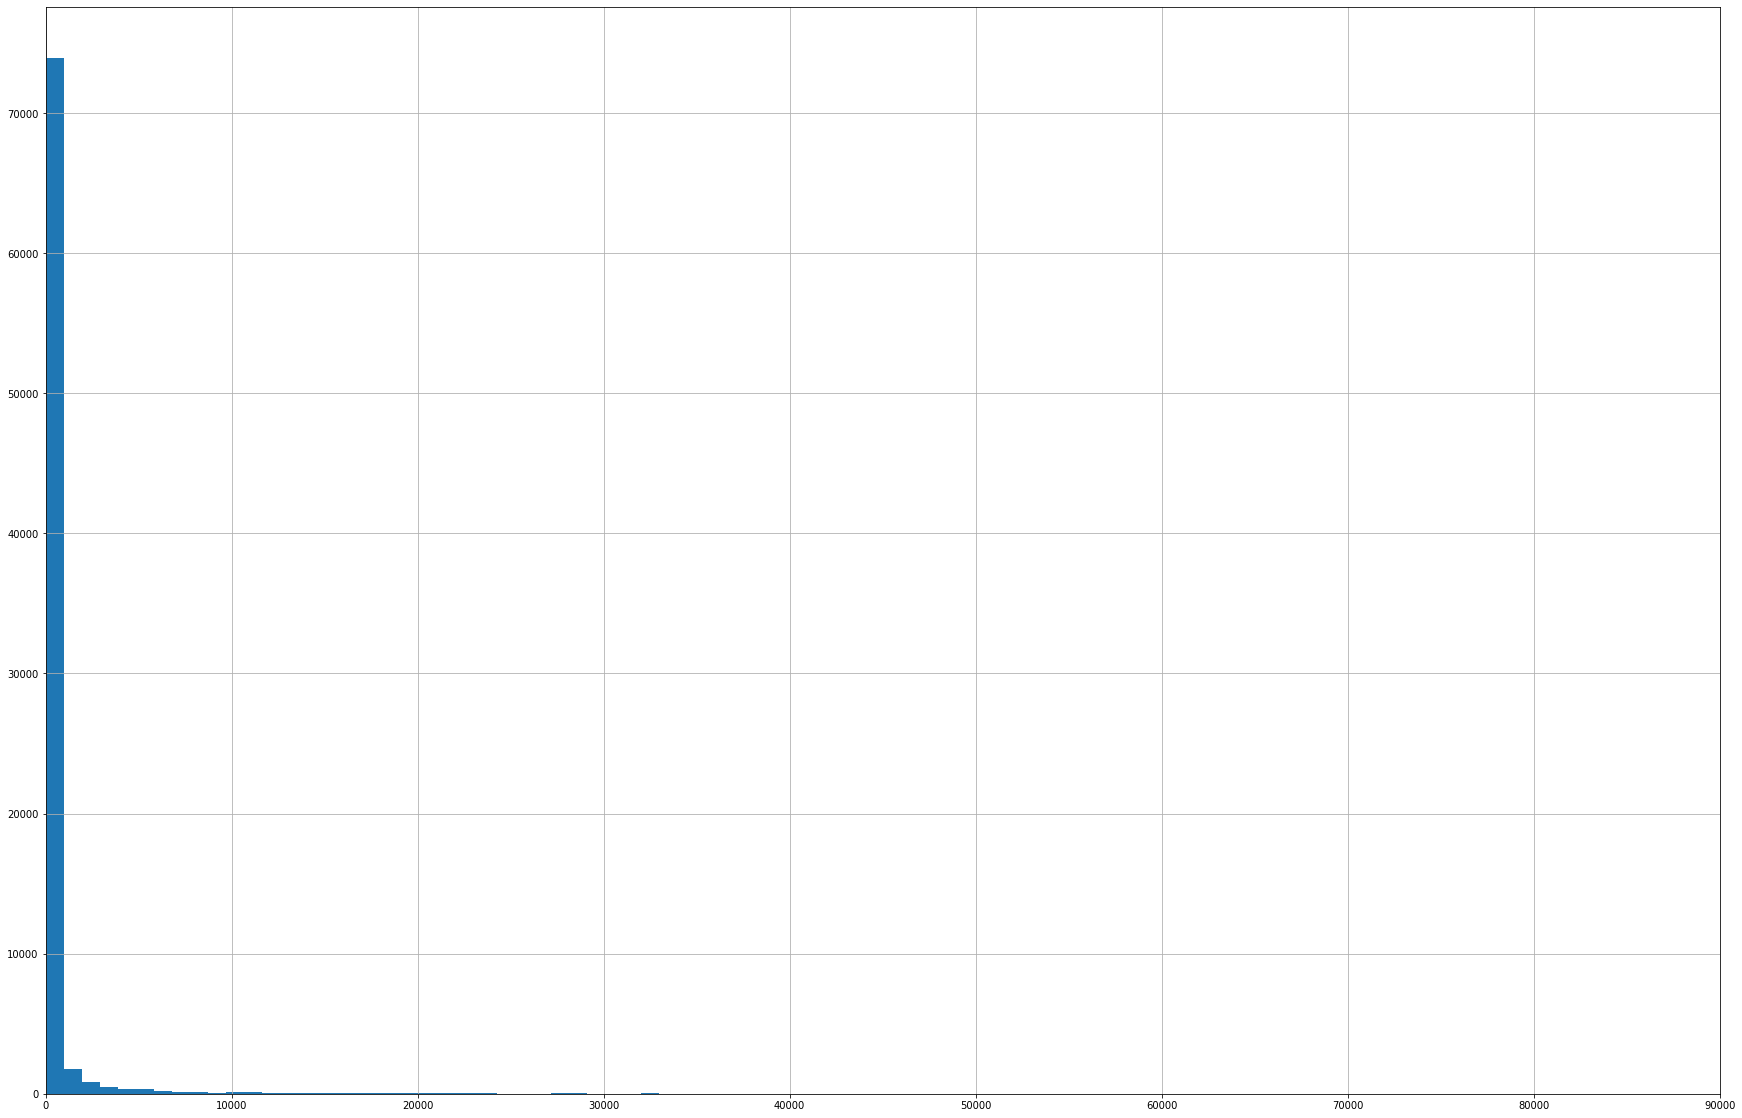

In [148]:
X_train['ratings_count'].hist(bins=100, figsize=(30,20))
plt.xlim([0, 90000])
plt.show()

In [149]:
ratings_count_train_min = np.min(X_train['ratings_count'])
ratings_count_train_max = np.max(X_train['ratings_count'])
ratings_count_train_range = ratings_count_train_max - ratings_count_train_min

X_train_minmaxscaled['ratings_count'] = (X_train['ratings_count'] - ratings_count_train_min) / ratings_count_train_range
X_val_minmaxscaled['ratings_count'] = (X_val['ratings_count'] - ratings_count_train_min) / ratings_count_train_range
X_test_minmaxscaled['ratings_count'] = (X_test['ratings_count'] - ratings_count_train_min) / ratings_count_train_range

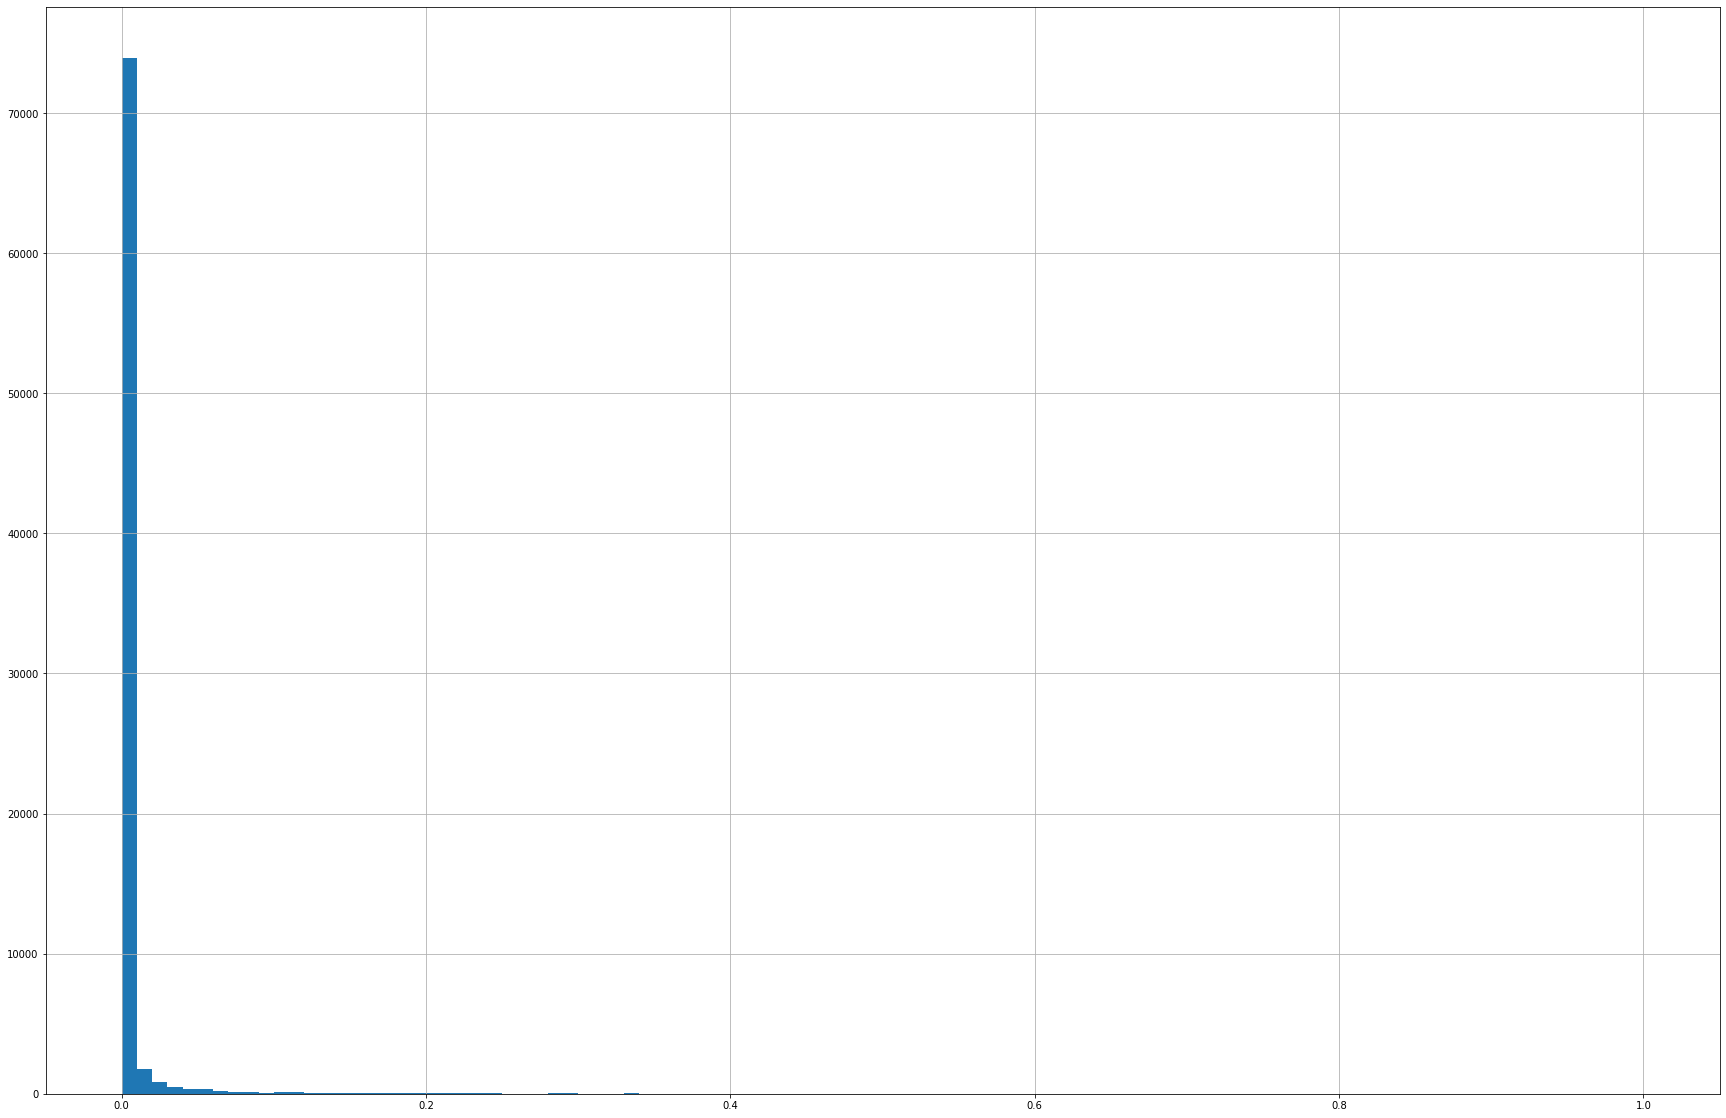

In [150]:
X_train_minmaxscaled['ratings_count'].hist(bins=100, figsize=(30,20))
plt.show()

In [151]:
len(X_train)

79659

### Evaluating normalization

L2 normalization is applied to each observation so the that the values in a row have a unit norm. Unit norm with L2 means that if each element were squared and summed, the total would equal 1

In [152]:
#X_train_normalized_l2 = X_train.copy()
#X_train_normalized_l2.iloc[:,:] = normalize(X_train, norm='l2')

# alternative code in slides
# x_norm2 = np.linalg.norm(x, ord=2)
# x_normalized = x / x_norm2

In [153]:
# X_train_normalized_l1 = X_train.copy()
# X_train_normalized_l1.iloc[:,:] = normalize(X_train, norm='l1')

In [154]:
# X_train_normalized_lmax = X_train.copy()
# X_train_normalized_lmax.iloc[:,:] = normalize(X_train, norm='max')

In [155]:
# X_train_normalized_SSRN = X_train.copy()
# X_train_normalized_SSRN.iloc[:,:] = np.sign(X_train)*np.sqrt(np.abs(X_train))

In [156]:
# X_train_minmaxscaled_normalized_SSRN = X_train.copy()
# X_train_minmaxscaled_normalized_SSRN.iloc[:,:] = np.sign(X_train_minmaxscaled)*np.sqrt(np.abs(X_train_minmaxscaled))

In [157]:
# X_train.iloc[:,:4].describe().loc[['mean', 'min', 'max']]

In [158]:
# display_side_by_side(
#     [
#         X_train_normalized_l2.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
#         X_train_normalized_l1.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
#         X_train_normalized_lmax.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
#         X_train_minmaxscaled.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
#         X_train_normalized_SSRN.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
#         X_train_minmaxscaled_normalized_SSRN.iloc[:,:4].describe().loc[['mean', 'min', 'max']]
#     ],
#     [
#         "X_train_normalized_l2",
#         "X_train_normalized_l1",
#         "X_train_normalized_lmax",
#         "X_train_minmaxscaled",
#         "X_train_normalized_SSRN",
#         "X_train_minmaxscaled_normalized_SSRN"
#     ])

### Dimensionality reduction

In [159]:
len(X_train_minmaxscaled.columns)

1150

#### LDA

In [160]:
lda = LinearDiscriminantAnalysis(solver= 'eigen')
lda.fit(X_train_minmaxscaled, y_train_categorical)

LinearDiscriminantAnalysis(solver='eigen')

In [161]:
print(lda.explained_variance_ratio_)

[0.43098243 0.30139464 0.13950173 0.05555456 0.02909396 0.02083623
 0.0159032  0.00673325]


Criterio di Kaiser o Variance Explained Cumulative Plot

In [162]:
s = 0
n = 1
for comp in lda.explained_variance_ratio_:
	s += comp
	if s > 0.95:
		break
	n += 1

n

5

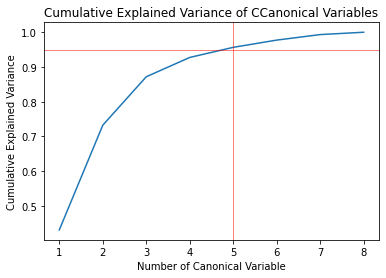

In [163]:
ax = figure().gca()
ax.plot(range(1, len(lda.explained_variance_ratio_) + 1), np.cumsum(lda.explained_variance_ratio_))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel('Number of Canonical Variable')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance of CCanonical Variables')

plt.axvline(x=5, linewidth=1, color='r', alpha=0.5)
plt.axhline(y=0.95, linewidth=1, color='r', alpha=0.5)
show()

In [164]:
X_train_minmaxscaled_reduced = lda.transform(X_train_minmaxscaled)

In [165]:
X_train_minmaxscaled_reduced = X_train_minmaxscaled_reduced[:,:5]

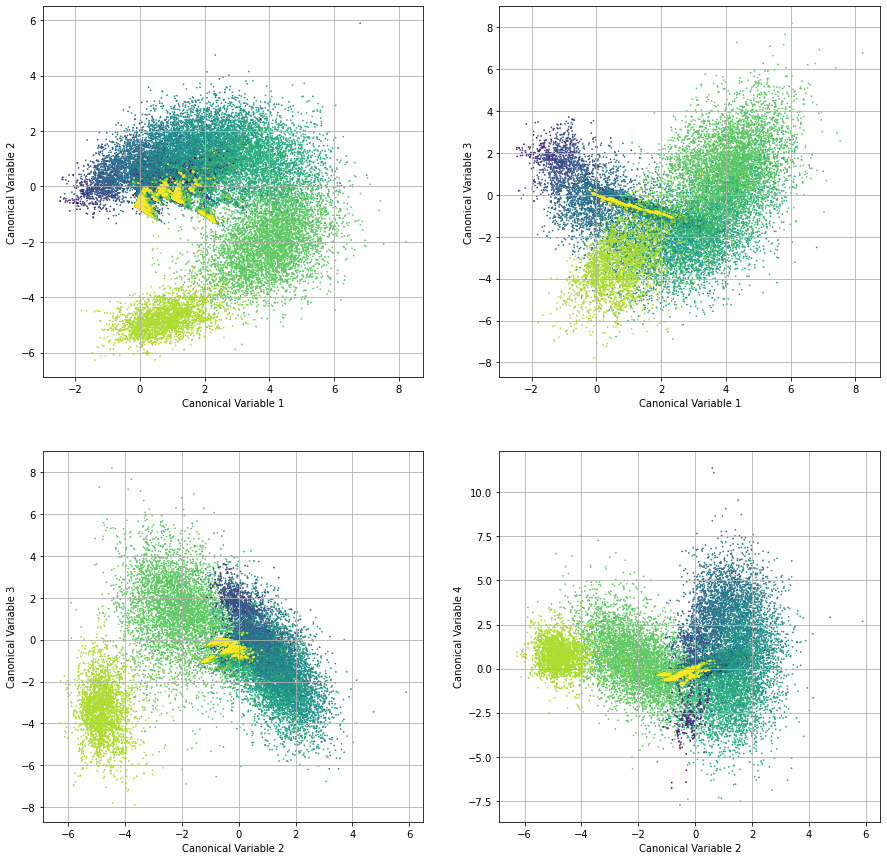

In [166]:
def myplot(n_cv1, n_cv2):
    cv1 = X_train_minmaxscaled_reduced[:, n_cv1 - 1]
    cv2 = X_train_minmaxscaled_reduced[:, n_cv2 - 1]

    plt.scatter(cv1 ,cv2, c = y_train_categorical, s = 0.5)

    plt.xlabel(f"Canonical Variable {n_cv1}")
    plt.ylabel(f"Canonical Variable {n_cv2}")
    plt.grid()

fig = plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
myplot(1, 2) 

plt.subplot(2, 2, 2)
myplot(1, 3) 

plt.subplot(2, 2, 3)
myplot(2, 3) 

plt.subplot(2, 2, 4)
myplot(2, 4) 

In [167]:
X_train_minmaxscaled_reduced.shape[1]

5

In [168]:
X_train_minmaxscaled_reduced = pd.DataFrame(
    X_train_minmaxscaled_reduced,
    columns = [f"LD{i}" for i in range(1, X_train_minmaxscaled_reduced.shape[1] + 1)])

In [169]:
X_val_minmaxscaled_reduced = pd.DataFrame(
    lda.transform(X_val_minmaxscaled)[:,:5],
    columns = [f"LD{i}" for i in range(1, X_train_minmaxscaled_reduced.shape[1] + 1)])
X_test_minmaxscaled_reduced = pd.DataFrame(
    lda.transform(X_test_minmaxscaled)[:,:5],
    columns = [f"LD{i}" for i in range(1, X_train_minmaxscaled_reduced.shape[1] + 1)])

# DATA MODELING

## Dataframe size reducing

In [170]:
X_train_minmaxscaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79659 entries, 0 to 101442
Columns: 1150 entries, year to ratings_count
dtypes: float64(1131), int64(19)
memory usage: 699.5 MB


In [171]:
# fcols = X_train_minmaxscaled.select_dtypes('float').columns
# icols = X_train_minmaxscaled.select_dtypes('integer').columns
# 
# X_train_minmaxscaled[fcols] = X_train_minmaxscaled[fcols].apply(pd.to_numeric, downcast='float')
# X_train_minmaxscaled[icols] = X_train_minmaxscaled[icols].apply(pd.to_numeric, downcast='integer')

In [ ]:
X_train_minmaxscaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83035 entries, 0 to 106928
Columns: 1150 entries, year to ratings_count
dtypes: float32(1131), int8(19)
memory usage: 360.4 MB


In [ ]:
if not os.path.exists("datasets-exported"):
    os.makedirs("datasets-exported")

In [ ]:
# X_train_minmaxscaled.to_csv(os.path.join("datasets-exported", "X_train_minmaxscaled"))

## SVM

più C è piccolo più l'error rate diminuisce (anche sul train)

C = 1000 | < 1 min

C = 100 | = 2 min

### Linear kernel

In [ ]:
svc = LinearSVC(random_state=13, C=1000, dual=False) #, tol=1e-5)
svc.fit(X_train_minmaxscaled, y_train_categorical)

LinearSVC(C=1000, dual=False, random_state=13)

#### prova sul train (deve dare error: 0)

In [ ]:
y_train_pred = svc.predict(X_train_minmaxscaled)

In [ ]:
print(zero_one_loss(y_train_categorical, y_train_pred))

0.6660712170857842


#### prova su test

In [ ]:
y_test_pred = svc.predict(X_test_minmaxscaled)

In [ ]:
print(zero_one_loss(y_test_categorical, y_test_pred))

0.6255457580686585


### Polinomial kernel

In [ ]:
svc = svm.SVC(kernel="poly", C=1000)
svc.fit(X_train_minmaxscaled, y_train_categorical)

SVC(C=1000, kernel='poly')

In [ ]:
y_test_pred = svc.predict(X_test_minmaxscaled)

In [ ]:
print(zero_one_loss(y_test_categorical, y_test_pred))

0.6186970293639243


In [ ]:
svc = svm.SVC(kernel="poly", C = 1)
svc.fit(X_train_minmaxscaled, y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled)
print(zero_one_loss(y_test_categorical, y_test_pred))

0.6000749976563232


In [ ]:
svc = svm.SVC(kernel="poly", C = 1)
svc.fit(X_train_minmaxscaled, y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled)
print(zero_one_loss(y_test_categorical, y_test_pred))

In [ ]:
svc = svm.SVC(kernel="poly", C = 0.1)
svc.fit(X_train_minmaxscaled, y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled)
print(zero_one_loss(y_test_categorical, y_test_pred))

0.682732642753189


In [ ]:
svc = svm.SVC(kernel="poly", C = 0.001)
svc.fit(X_train_minmaxscaled, y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled)
print(zero_one_loss(y_test_categorical, y_test_pred))

### Rbf kernel

In [ ]:
svc = svm.SVC(kernel="rbf", C=1000)
svc.fit(X_train_minmaxscaled, y_train_categorical)

SVC(C=1000)

In [ ]:
y_test_pred = svc.predict(X_test_minmaxscaled)

In [ ]:
print(zero_one_loss(y_test_categorical, y_test_pred))

0.6114202551151442


In [ ]:
svc = svm.SVC(kernel="rbf", C=1)
svc.fit(X_train_minmaxscaled, y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled)
print(zero_one_loss(y_test_categorical, y_test_pred))

In [ ]:
svc = svm.SVC(kernel="rbf", C=0.1)
svc.fit(X_train_minmaxscaled, y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled)
print(zero_one_loss(y_test_categorical, y_test_pred))

In [ ]:
svc = svm.SVC(kernel="rbf", C=0.001)
svc.fit(X_train_minmaxscaled, y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled)
print(zero_one_loss(y_test_categorical, y_test_pred))

In [ ]:
svc = svm.SVC(kernel="rbf", C=1000)
svc.fit(X_train_minmaxscaled_reduced, y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled_reduced)
print(zero_one_loss(y_test_categorical, y_test_pred))

0.5949189087841005


In [ ]:
svc = svm.SVC(kernel="rbf", C=1)
svc.fit(X_train_minmaxscaled_reduced, y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled_reduced)
print(zero_one_loss(y_test_categorical, y_test_pred))

0.5963251148401613


In [ ]:
svc = svm.SVC(kernel="rbf", C=0.1)
svc.fit(X_train_minmaxscaled_reduced, y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled_reduced)
print(zero_one_loss(y_test_categorical, y_test_pred))

In [ ]:
svc = svm.SVC(kernel="rbf", C=0.001)
svc.fit(X_train_minmaxscaled_reduced, y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled_reduced)
print(zero_one_loss(y_test_categorical, y_test_pred))

0.6312927721008719


In [ ]:
X_train_minmaxscaled_reduced.columns

Index(['LD1', 'LD2', 'LD3', 'LD4', 'LD5'], dtype='object')

In [ ]:
svc = svm.SVC(kernel="rbf", C=1000)
svc.fit(X_train_minmaxscaled_reduced.loc[:, ['LD1', 'LD2']], y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled_reduced.loc[:, ['LD1', 'LD2']])
print(zero_one_loss(y_test_categorical, y_test_pred))

0.5948251617136964


In [ ]:
svc = svm.SVC(kernel="rbf", C=1000)
svc.fit(X_train_minmaxscaled_reduced.loc[:, ['LD2', 'LD3']], y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled_reduced.loc[:, ['LD1', 'LD2']])
print(zero_one_loss(y_test_categorical, y_test_pred))

/public/mick.perl/DataAnalyticsProject/venv/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- LD1
Feature names seen at fit time, yet now missing:
- LD3

  warnings.warn(message, FutureWarning)


0.7627261648073498


### Sigmoid kernel

In [ ]:
svc = svm.SVC(kernel="sigmoid", C=1000)
svc.fit(X_train_minmaxscaled, y_train_categorical)

In [ ]:
y_test_pred = svc.predict(X_test_minmaxscaled)

In [ ]:
print(zero_one_loss(y_test_categorical, y_test_pred))

In [ ]:
svc = svm.SVC(kernel="sigmoid", C=1)
svc.fit(X_train_minmaxscaled, y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled)
print(zero_one_loss(y_test_categorical, y_test_pred))

In [ ]:
svc = svm.SVC(kernel="sigmoid", C=0.1)
svc.fit(X_train_minmaxscaled, y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled)
print(zero_one_loss(y_test_categorical, y_test_pred))

In [ ]:
svc = svm.SVC(kernel="sigmoid", C=0.001)
svc.fit(X_train_minmaxscaled, y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled)
print(zero_one_loss(y_test_categorical, y_test_pred))

In [ ]:
svc = svm.SVC(kernel="sigmoid", C=1)
svc.fit(X_train_minmaxscaled_reduced, y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled_reduced)
print(zero_one_loss(y_test_categorical, y_test_pred))

0.8314427674135183


In [ ]:
svc = svm.SVC(kernel="sigmoid", C=0.1)
svc.fit(X_train_minmaxscaled_reduced, y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled_reduced)
print(zero_one_loss(y_test_categorical, y_test_pred))

In [ ]:
svc = svm.SVC(kernel="sigmoid", C=0.001)
svc.fit(X_train_minmaxscaled_reduced, y_train_categorical)
y_test_pred = svc.predict(X_test_minmaxscaled_reduced)
print(zero_one_loss(y_test_categorical, y_test_pred))

0.6832286491047155


### Custom kernel

#### Feature Engineering

Nella teoria dell'informazione, la distanza di Hamming tra due stringhe di ugual lunghezza è il numero di posizioni nelle quali i simboli corrispondenti sono diversi. 

We want to measure distances between samples by separately considering tags and genres: by the way, we have created two new columns:
- `genres` which collapses in a list the values corresponding to genres' columns;
- `tags` which collapses in a list the values corresponding to tags' columns.

In [ ]:
## Ogni tecnica dovrà diventare una funzione parametrica: uno dei parametri dovrà essere sicuramente il dataset di train 
# in questo caso è X_train_minmaxscaled 

X_train_SVC = X_train_minmaxscaled.loc[:,["year", "title_length", "ratings_count"]]
X_train_SVC['genres'] = X_train_minmaxscaled.iloc[:,2:21].values.tolist()
X_train_SVC['tags'] = X_train_minmaxscaled.iloc[:,22:-1].values.tolist()
# df_train_SVC = X_train_SVC.copy()
# df_train_SVC['bin_y'] = y_train_categorical

X_test_SVC = X_test_minmaxscaled.loc[:,["year", "title_length", "ratings_count"]]
X_test_SVC['genres'] = X_test_minmaxscaled.iloc[:,2:21].values.tolist()
X_test_SVC['tags'] = X_test_minmaxscaled.iloc[:,22:-1].values.tolist()
# df_test_SVC = X_test_SVC.copy()
# df_test_SVC['bin_y'] = y_test_categorical

In [ ]:
df_train_SVC_light = df_train_SVC.sample(n=1000, random_state=13)
df_train_SVC_light = df_train_SVC_light.reset_index(drop=True)

df_test_SVC_light = df_test_SVC.sample(n=100, random_state=13)
df_test_SVC_light = df_test_SVC_light.reset_index(drop=True)

In [ ]:
X_train_light = df_train_SVC_light.iloc[:, 0:-1]
y_train_light = df_train_SVC_light['bin_y']

X_test_light = df_test_SVC_light.iloc[:, 0:-1]
y_test_light = df_test_SVC_light['bin_y']

#### Execution

In [ ]:
def distance(a,b):
	d = np.sqrt(np.square(np.subtract(a[0:3], b[0:3])).sum())     # distanze element wise tra year, title_length e ratings_count
	d += np.sqrt(np.bitwise_xor(a[3], b[3]).sum()) # hamming
	d += np.sqrt(np.square(np.subtract(a[4], b[4])).sum())
	return d

In [ ]:
train_distances = cdist(X_train_SVC.values, X_train_SVC.values, lambda a,b: distance(a,b))

MemoryError: Unable to allocate 51.4 GiB for an array with shape (83035, 83035) and data type float64

In [ ]:
# Questa è la soluzione
# !sudo echo 1 > /proc/sys/vm/overcommit_memory
# https://coderedirect.com/questions/56152/unable-to-allocate-array-with-shape-and-data-type

/bin/bash: /proc/sys/vm/overcommit_memory: Permission denied


In [ ]:
a = np.zeros((156816, 36, 53806), dtype='uint8')

MemoryError: Unable to allocate 283. GiB for an array with shape (156816, 36, 53806) and data type uint8

In [ ]:
svc = svm.SVC(kernel="precomputed", C=1000)
svc.fit(train_distances, y_train_categorical)

SVC(C=1000, kernel='precomputed')

In [ ]:
test_distances = cdist(X_test_SVC.values, X_train_SVC.values, lambda a,b: distance(a,b))

In [ ]:
y_test_pred = svc.predict(test_distances)

Error rate

In [ ]:
print(zero_one_loss(y_test_categorical, y_test_pred))

0.99


In [ ]:
svc = svm.SVC(kernel="precomputed", C=1)
svc.fit(train_distances, y_train_categorical)
y_test_pred = svc.predict(test_distances)
print(zero_one_loss(y_test_categorical, y_test_pred))

In [ ]:
svc = svm.SVC(kernel="precomputed", C=0.1)
svc.fit(train_distances, y_train_categorical)
y_test_pred = svc.predict(test_distances)
print(zero_one_loss(y_test_categorical, y_test_pred))

In [ ]:
svc = svm.SVC(kernel="precomputed", C=0.001)
svc.fit(train_distances, y_train_categorical)
y_test_pred = svc.predict(test_distances)
print(zero_one_loss(y_test_categorical, y_test_pred))

In [ ]:
# assert_array_equal(svc.dual_coef_, [[-0.25, 0.25]])
# assert_array_equal(svc.support_, [1, 3])
# assert_array_equal(svc.intercept_, [0])
# assert_array_almost_equal(svc.support_, [1, 3])
# assert_array_equal(pred, y_test_categorical)

## Naive Bayes

### Pre-processing

In [ ]:
X_train_NB = X_train.copy()
X_train_NB.drop('ratings_count', inplace=True, axis=1)

In [ ]:
X_test_NB = X_test.copy()
X_test_NB.drop('ratings_count', inplace=True, axis=1)

In [ ]:
# riprendere la conclusione ottenuta in "Evaluating Standardization" per giustificare il fatto che si procede con standardizzazione

In [ ]:
X_train_NB.iloc[:, 24].describe()

count    83035.000000
mean         0.016807
std          0.050467
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.908750
Name: 1920s, dtype: float64

In [ ]:
X_train_NB.iloc[:, 24].value_counts(bins=4, sort=False)

(-0.00193, 0.232]    79080
(0.232, 0.465]         613
(0.465, 0.698]          95
(0.698, 0.93]           24
Name: 1920s, dtype: int64

In [ ]:
X_train_NB.iloc[:, 21:-1] = X_train_NB.iloc[:, 21:-1].apply(lambda x: pd.cut(x, 4, labels=range(4)))

In [ ]:
X_test_NB.iloc[:, 21:-1] = X_test_NB.iloc[:, 21:-1].apply(lambda x: pd.cut(x, 4, labels=range(4)))

### Categorical Naive Bayes

In [ ]:
clf = CategoricalNB()
clf.fit(X_train_NB, y_train_categorical, sample_weight=X_train.ratings_count)

CategoricalNB()

In [ ]:
y_test_predict = clf.predict(X_test_NB) # inutile (viene fatto all'interno di score)

In [ ]:
clf.score(X_test_NB, y_test_categorical)

0.18475750577367206

In [ ]:
X_train_reduced_NB = X_train_minmaxscaled_reduced.copy()
X_train_reduced_NB = X_train_reduced_NB.apply(lambda x: pd.cut(x, 4, labels=range(4)))
X_test_reduced_NB = X_test_minmaxscaled_reduced.copy()
X_test_reduced_NB= X_test_reduced_NB.apply(lambda x: pd.cut(x, 4, labels=range(4)))
clf = CategoricalNB()
clf.fit(X_train_reduced_NB, y_train_categorical, sample_weight=X_train.ratings_count)
y_test_predict = clf.predict(X_test_reduced_NB)
clf.score(X_test_reduced_NB, y_test_categorical)

0.36730595441309366

## Random Forest

#### Categorical Labels

In [111]:
rf = RandomForestClassifier(n_estimators=500, random_state = 43, criterion = "entropy", n_jobs=-1)
rf.fit(X_train, y_train_categorical)
# rf.predict(X_test)
print("Avg accuracy: ", rf.score(X_test, y_test_categorical))

In [590]:
rf = RandomForestClassifier(n_estimators=500, random_state = 43, criterion = "entropy", n_jobs=-1, class_weight = "balanced")
rf.fit(X_train, y_train_categorical)
# rf.predict(X_test)
print("Avg accuracy: ", rf.score(X_test, y_test_categorical))

Avg accuracy:  0.39742946078923586


In [ ]:
rf = RandomForestClassifier(n_estimators=500, random_state = 43, n_jobs=-1, class_weight = "balanced")
rf.fit(X_train, y_train_categorical)
# rf.predict(X_test)
print("Avg accuracy: ", rf.score(X_test, y_test_categorical))

In [ ]:
rankVar = pd.Series(rf.feature_importances_, index=df_X.columns).sort_values(ascending=False)
print(rankVar)

In [ ]:
sns.barplot(x=rankVar, y=rankVar.index)
plt.xlabel('Variable Importance Score')
plt.ylabel('Variables')
plt.legend()
plt.show()

In [ ]:
# max_features = "log2" # nr di feature da selezionare randomicamente per ogni decision tree
criterion = "entropy"
bootstrap = False # If False, the whole dataset is used to build each tree.
class_weight # provare
    # 'balanced' se bootstrap lasciato a True (default)
    # 'balanced_subsample' se bootstrap è False
    # passargli un dizionario che mappa ad ogni class label la somma dei ratings_count che vi rientrano oppure utilizzare questo weight come parametro della fit

#### Continuous Labels

In [112]:
rf = RandomForestRegressor(n_estimators=500, random_state = 43, n_jobs=-1)
rf.fit(X_train, y_train_continuous)
# rf.predict(X_test)
print("Avg accuracy: ", rf.score(X_test, y_test_continuous))

KeyboardInterrupt: 

In [ ]:
rf = RandomForestRegressor(n_estimators=500, random_state = 43, n_jobs=-1)
rf.fit(X_train_minmaxscaled, y_train_continuous)
# rf.predict(X_test)
print("Avg accuracy: ", rf.score(X_test_minmaxscaled, y_test_continuous))

In [ ]:
criterion = "poisson" # provare anche "absolute_error" ma attenzione molto più lento
max_features = "log2" # nr di feature da selezionare randomicamente per ogni decision tree
bootstrap = False # If False, the whole dataset is used to build each tree.
# provare parametro weight nella fit, passandogli ratings_count

## Multi Layer Perceptron